In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [10]:
# Carregar o dataset
data_path = "C:/Users/afili/Desktop/Uni/Mestrado/AASE/apartments_for_rent_10k_final.csv" 
data = pd.read_csv(data_path, sep=';')

In [12]:
# Codificar as colunas categóricas
le = LabelEncoder()
data["cityname_transformed"] = le.fit_transform(data["cityname_transformed"])
data["pets_allowed_transformed"] = le.fit_transform(data["pets_allowed_transformed"])
data["has_photo_transformed"] = le.fit_transform(data["has_photo_transformed"])
data["price_class"] = le.fit_transform(data["price_class"])


In [13]:
numerical_features = ['price', 'square_feet', 'bathrooms', 'bedrooms']

def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

data_cleaned = remove_outliers(data, numerical_features)

print(f"Tamanho original do dataset: {data.shape}")
print(f"Tamanho após remoção de outliers: {data_cleaned.shape}")

Tamanho original do dataset: (9994, 53)
Tamanho após remoção de outliers: (8546, 53)


In [5]:
output_file = 'C:/Users/afili/Desktop/Uni/Mestrado/AASE/apartamentos_10k_remoçaoOutliers.csv'
data_cleaned.to_csv(output_file, index=False)

In [14]:
# Selecionar features e target
features = [
    "bathrooms", "bedrooms", "square_feet", "pets_allowed_transformed", "has_photo_transformed", "cityname_transformed", "AC", 
    "Alarm", "Basketball", "Cable or Satellite", "Clubhouse", "Dishwasher", "Doorman", 
    "Elevator", "Fireplace", "Garbage Disposal", "Gated", "Golf", "Gym", "Hot Tub", 
    "Internet Access", "Luxury", "Parking", "Patio/Deck", "Playground", "Pool", 
    "Refrigerator", "Storage", "TV", "Tennis", "View", "Washer Dryer", "Wood Floors"
]
target = "price"

X = data_cleaned[features]
y = data_cleaned[target]

# Tratar valores ausentes na variável target
y = y.fillna(y.mean())

In [15]:
# 1. Divisão dos dados em treino/validação/teste
y_classificacao = data_cleaned['price_class'] #Variável alvo para classificação
X_train_val, X_test, y_train_val, y_test, y_train_val_classificacao, y_test_classificacao = train_test_split(X, y, y_classificacao, test_size=0.2, random_state=42)  # Teste
X_train, X_val, y_train, y_val, y_train_classificacao, y_val_classificacao = train_test_split(X_train_val, y_train_val, y_train_val_classificacao, test_size=0.25, random_state=42) # Validação (0.25*0.8 = 0.2)

In [21]:
# Definição das métricas de avaliação
scoring = {'r2': 'r2', 'rmse': 'neg_root_mean_squared_error', 'mae': 'neg_mean_absolute_error'}

kf = KFold(n_splits=10, shuffle=True, random_state=42) #Validação cruzada com 5 folds

In [22]:
model = DecisionTreeRegressor(random_state=42)


In [23]:
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [24]:
search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=10,
    n_jobs=-1
)

In [25]:
search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error')

In [26]:
best_model = search.best_estimator_
print("Melhores hiperparâmetros:", search.best_params_)

Melhores hiperparâmetros: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [29]:
# Avaliar modelo
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred = best_model.predict(X_test)

# Cálculo das métricas de regressão
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
nmae = mae / np.mean(np.abs(y_test)) * 100  # Percentual em relação à média dos valores reais
r2 = r2_score(y_test, y_pred)

# Exibir os resultados
print("Decision Tree- Mean Squared Error (MSE):", mse)
print("Decision Tree- Mean Absolute Error (MAE):", mae)
print("Decision Tree- Root Mean Squared Error (RMSE):", rmse)
print("Decision Tree- Normalized Mean Absolute Error (NMAE):", f"{nmae:.2f}%")
print("Decision Tree- R² Score:", r2)

Decision Tree- Mean Squared Error (MSE): 204248.77077895726
Decision Tree- Mean Absolute Error (MAE): 346.73938536629265
Decision Tree- Root Mean Squared Error (RMSE): 451.93890159949416
Decision Tree- Normalized Mean Absolute Error (NMAE): 27.04%
Decision Tree- R² Score: 0.14492509099900186


In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Definição dos hiperparâmetros para testar
param_distributions_rf = {
    'n_estimators': [300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [31]:
rf = RandomForestRegressor(random_state=42)

In [32]:
random_search_rf = RandomizedSearchCV(rf, param_distributions=param_distributions_rf, n_iter=50, cv=kf, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1) #n_jobs=-1 para usar todos os cores do processador.
random_search_rf.fit(X_train, y_train)

c:\Users\afili\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 45 is smaller than n_iter=50. Running 45 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=RandomForestRegressor(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30, 40],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [300]},
                   random_state=42, scoring='neg_mean_squared_error')

In [33]:
best_params_rf = random_search_rf.best_params_
print(f"Melhores hiperparâmetros para Random Forest: {best_params_rf}")

Melhores hiperparâmetros para Random Forest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10}


In [41]:
model_rf = RandomForestRegressor(**best_params_rf, random_state=42)
scores_rf = cross_validate(model_rf, X_train_val, y_train_val, cv=kf, scoring=scoring)

print("\nRandom Forest - Validação Cruzada:")
for metric in scoring:
    mean_score = -scores_rf[f'test_{metric}'].mean() if metric in ('rmse', 'mae') else scores_rf[f'test_{metric}'].mean()
    std_score = scores_rf[f'test_{metric}'].std()
    print(f"{metric.upper()}: {mean_score:.4f} (+/- {std_score:.4f})")

model_rf.fit(X_train_val, y_train_val)

y_pred_test_rf = model_rf.predict(X_test)

mse_test_rf = mean_squared_error(y_test, y_pred_test_rf)
mae_test_rf = mean_absolute_error(y_test, y_pred_test_rf)
rmse_test_rf = np.sqrt(mse_test_rf)
nmae_test_rf = mae_test_rf / np.mean(np.abs(y_test)) * 100 
r2_test_rf = r2_score(y_test, y_pred_test_rf)

print("\nRandom Forest - Resultados no Conjunto de Teste:")
print(f"Mean Squared Error (MSE): {mse_test_rf:.4f}")
print(f"Mean Absolute Error (MAE): {mae_test_rf:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_test_rf:.4f}")
print(f"Normalized Mean Absolute Error (NMAE): {nmae_test_rf:.2f}%")
print(f"R² Score: {r2_test_rf:.4f}")



Random Forest - Validação Cruzada:
R2: 0.2161 (+/- 0.0245)
RMSE: 424.9949 (+/- 11.7096)
MAE: 328.6478 (+/- 6.4390)

Random Forest - Resultados no Conjunto de Teste:
Mean Squared Error (MSE): 180046.4761
Mean Absolute Error (MAE): 323.9583
Root Mean Squared Error (RMSE): 424.3188
Normalized Mean Absolute Error (NMAE): 25.26%
R² Score: 0.2462


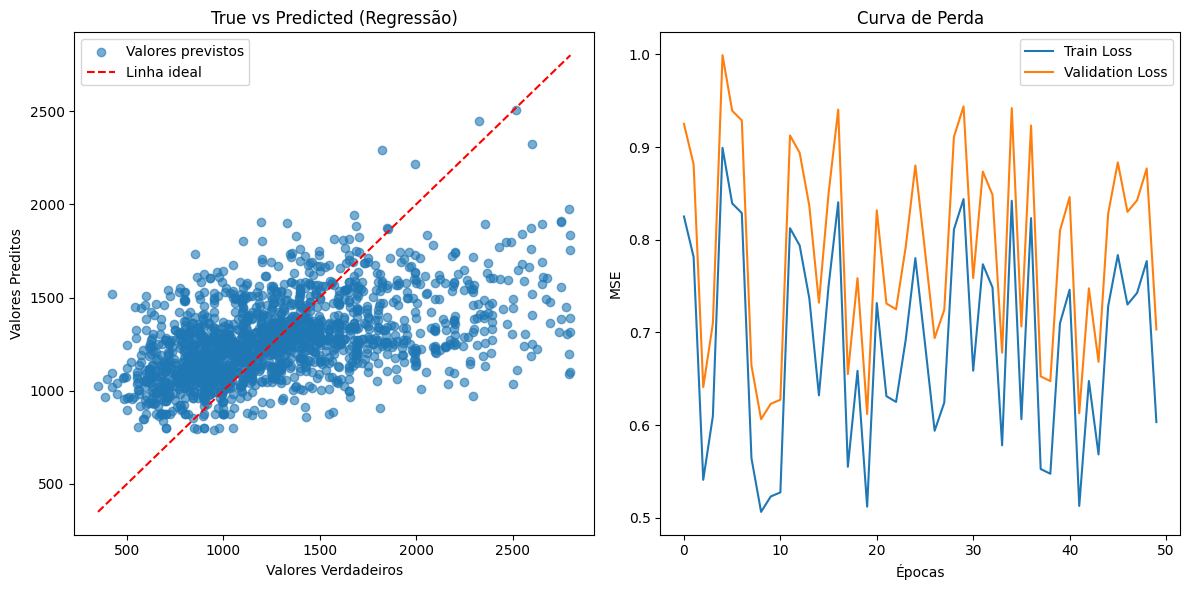

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Gráfico: Valores Verdadeiros vs Preditos
plt.figure(figsize=(12, 6))

# Scatter plot de valores verdadeiros vs preditos
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test_rf, alpha=0.6, label="Valores previstos")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--", label="Linha ideal")
plt.xlabel("Valores Verdadeiros")
plt.ylabel("Valores Preditos")
plt.title("True vs Predicted (Regressão)")
plt.legend()

# Gráfico: Curva de Perda (simulado para modelo iterativo)
# Caso não tenha um histórico de perda, este exemplo é para ilustração
val_loss = np.random.uniform(0.6, 1.0, size=50)  # Simulando valores de perda de validação
loss = val_loss - 0.1  # Simulando valores de perda de treino
plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label="Train Loss")
plt.plot(range(len(val_loss)), val_loss, label="Validation Loss")
plt.xlabel("Épocas")
plt.ylabel("MSE")
plt.title("Curva de Perda")
plt.legend()

plt.tight_layout()
plt.show()


In [183]:
X_new = data_cleaned[features]

X_new = X_new.fillna(0)

data_cleaned['predicted_price'] = model_rf.predict(X_new)

output_file = 'C:/Users/afili/Desktop/Uni/Mestrado/AASE/predicted_price.csv'
data_cleaned[['predicted_price']].to_csv(output_file, index=False)
print(f"Arquivo salvo com sucesso: {output_file}")


Arquivo salvo com sucesso: C:/Users/afili/Desktop/Uni/Mestrado/AASE/predicted_price.csv


In [184]:
print("Shape de X_selected_reg:", X_new.shape)
print("Shape de data:", data_cleaned.shape)


Shape de X_selected_reg: (8546, 33)
Shape de data: (8546, 54)
